In [3]:
!pip install pyyaml h5py
!pip install tensorflow==2.9.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 65.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 78.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 96.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 96.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    U

In [27]:
from tensorflow.keras.applications.efficientnet import EfficientNetB6
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.data import AUTOTUNE
import tensorflow as tf
from tensorflow import keras
import sys
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
data = pathlib.Path('/content/gdrive/MyDrive/wildlife_presence')
test = pathlib.Path('/content/gdrive/MyDrive/test')
top_checkpoint_path = pathlib.Path('/content/gdrive/MyDrive/top_layer_training/cp.ckpt')
std_checkpoint_path = pathlib.Path('/content/gdrive/MyDrive?std_training/cp.ckpt')

In [7]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

Not connected to a TPU runtime. Using CPU/GPU strategy


# New Section

In [8]:
img_path = data
test_path = test
img_size = 528
batch_size=32
classes = 2

In [9]:
# Modified Network allowing for transfer learning
def build_efficientnet():
    inputs = layers.Input(shape=(img_size, img_size, 3))  # Construct the expected image input
    model = EfficientNetB6(include_top=False,
                           input_tensor=inputs,
                           weights='imagenet')  # Initialize efficientnet model with imagenet weights
    model.trainable = False  # Freeze the pre-trained weights

    # Rebuild the top layers
    x = Sequential()
    x = model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(2048, activation='relu')(x)
    predictions = Dense(classes, activation='softmax')(x)

    # Initialize model
    model = Model(inputs=model.input, outputs=predictions, name='EfficientNet')
    optimizer = Adam(learning_rate=1e-2)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model


In [19]:
def import_dataset(file_path: str):

    train_ds = image_dataset_from_directory(directory=file_path,
                                            validation_split=0.2,
                                            subset='training',
                                            seed=123,
                                            image_size=(img_size, img_size),
                                            batch_size=batch_size,
                                            labels='inferred',
                                            label_mode='categorical')
    val_ds = image_dataset_from_directory(directory=file_path,
                                          validation_split=0.2,
                                          subset='validation',
                                          seed=123,
                                          image_size=(img_size, img_size),
                                          batch_size=batch_size,
                                          labels='inferred',
                                          label_mode='categorical')

    print(train_ds.class_names)
    return train_ds, val_ds

In [13]:
def generate_test_set(file_path: str):
  test_ds = image_dataset_from_directory(directory=file_path,
                                         seed=123,
                                         image_size=(img_size, img_size),
                                         labels='inferred',
                                         label_mode='categorical')
  print(test_ds.class_names)
  return test_ds

In [14]:
def train_top_weights(train_ds, test_ds):
  with strategy.scope():
    model = build_efficientnet()


  epochs = 25
  hist = model.fit(train_ds, 
                   epochs=epochs, 
                   validation_data=test_ds, 
                   verbose=2)
  return model, hist

In [15]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history['val_accuracy'])
    plt.title("Wildlife Presence Accuracy")
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"])
    plt.show

In [16]:
def reload_model_top():
  model = build_efficientnet()
  latest_weights = tf.train.latest_checkpoint(top_checkpoint_path)
  model.load_weights(latest_weights)
  return model

In [20]:
# Generate dataset and pre-tune
train_ds, eval_ds = import_dataset(img_path)
test_ds = generate_test_set(test)

train_ds = train_ds.prefetch(AUTOTUNE) 

model, hist = train_top_weights(train_ds, eval_ds)

Found 695 files belonging to 2 classes.
Using 556 files for training.
Found 695 files belonging to 2 classes.
Using 139 files for validation.
['Absent', 'Present']
Found 54 files belonging to 2 classes.
['Absent', 'Present']
165234480/165234480 [==============================] - 1s 0us/step
Epoch 1/25
18/18 - 107s - loss: 1.0926 - accuracy: 0.9047 - val_loss: 0.6077 - val_accuracy: 0.9424 - 107s/epoch - 6s/step
Epoch 2/25
18/18 - 33s - loss: 0.1943 - accuracy: 0.9820 - val_loss: 0.2694 - val_accuracy: 0.9353 - 33s/epoch - 2s/step
Epoch 3/25
18/18 - 33s - loss: 0.0268 - accuracy: 0.9820 - val_loss: 0.2604 - val_accuracy: 0.9353 - 33s/epoch - 2s/step
Epoch 4/25
18/18 - 33s - loss: 0.0242 - accuracy: 0.9892 - val_loss: 0.2524 - val_accuracy: 0.9281 - 33s/epoch - 2s/step
Epoch 5/25
18/18 - 34s - loss: 0.0255 - accuracy: 0.9928 - val_loss: 0.2221 - val_accuracy: 0.8921 - 34s/epoch - 2s/step
Epoch 6/25
18/18 - 36s - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.2484 - val_accuracy: 0.9353 - 

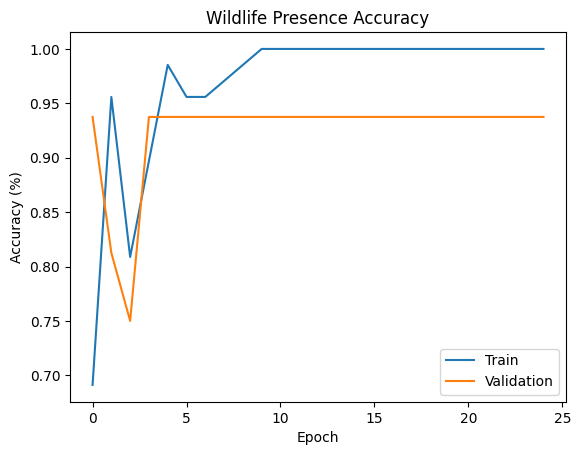

In [13]:
plot_hist(hist)

In [21]:
preds = model.predict(test_ds)

2/2 [==============================] - 21s 4s/step


In [29]:
y_pred = np.argmax(preds, axis=1)
print(y_pred)

[1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 1 1]
